In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from sklearn.decomposition import PCA, IncrementalPCA
from tqdm import tqdm

%matplotlib inline

In [3]:
def rgb2gray(rgb):
    if len(rgb.shape) > 2: return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    else: return rgb

In [4]:
def normalization_min_max(X):
    return (X - X.min()) / (X.max() - X.min())

### Load the data

In [5]:
faces = sorted(glob.glob("Faces/*"))

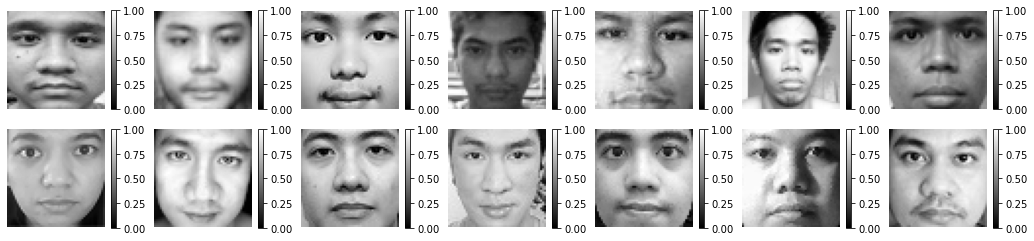

In [6]:
plt.figure(figsize = (1*9*2,1*2*2))

for i,j in enumerate(range(0,70,5)):
    plt.subplot(2,7,i+1)
    plt.imshow(normalization_min_max(rgb2gray(plt.imread(faces[j]))), cmap = 'gray')
    plt.colorbar()
    plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.2)
#plt.savefig('Figures/faces_colorbar_norm.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### Apply PCA and record metrics

In [7]:
X = np.array([rgb2gray(plt.imread(i)).flatten() for i in faces])

pca = PCA(len(faces))
pca.fit(X)

mean = pca.mean_
evecs = pca.components_
evals = pca.explained_variance_ratio_

explained = pca.explained_variance_ratio_.cumsum() * 100

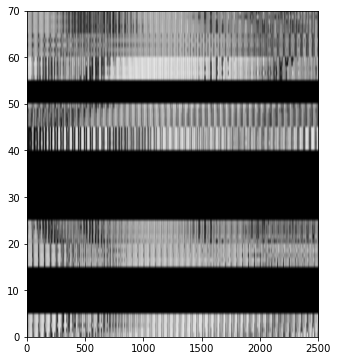

In [8]:
#Dataset
plt.figure(figsize = (6,6))
plt.imshow(X, cmap = 'gray',  extent = [0, 2500, 0, 70], aspect = 40)
#plt.savefig('Figures/flattened_image.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### Measure number of principal components required to explain 99%

In [9]:
accuracy = 99
k = np.argmax(explained>accuracy)
print("Number of components explaining 99% variance: "+ str(k+1))

Number of components explaining 99% variance: 15


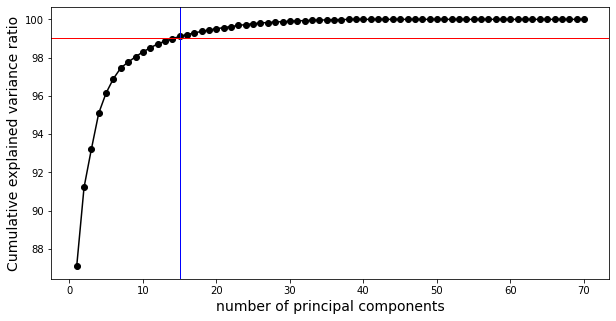

In [10]:
plt.figure(figsize=[10,5])
plt.plot(np.arange(0,len(faces))+1, explained, 'o-', color = 'black')
plt.ylabel('Cumulative explained variance ratio', fontsize = 14)
plt.xlabel('number of principal components', fontsize = 14)
plt.axvline(x=k+1, color="blue", linewidth = 1)
plt.axhline(y=accuracy, color="red", linewidth = 1)
#plt.savefig('Figures/variance_explained.png', bbox_inches = 'tight', dpi = 200)
plt.show()

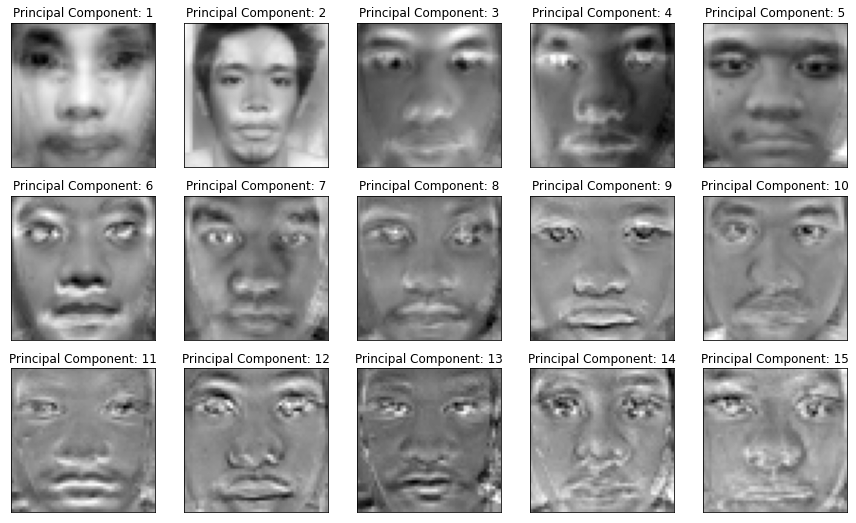

In [11]:
plt.figure(figsize = (15,9))
for i in range(15):
    plt.subplot(3,5,i+1)
    pc = evecs[i].reshape((50,50))
    plt.imshow(pc, cmap = 'gray')
    plt.title('Principal Component: ' + str(i+1))
    plt.xticks([])
    plt.yticks([])
#plt.savefig('Figures/principal_components.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### Reconstruct image using the 15 PCs

In [12]:
def reconstruct_image(k, test, mean):
    PC = evecs[0:k,].T
    test_less_mean = test - mean
    a = PC.T @ test_less_mean
    recons = PC @ a
    recons_plus_mean= recons + mean
    return recons_plus_mean

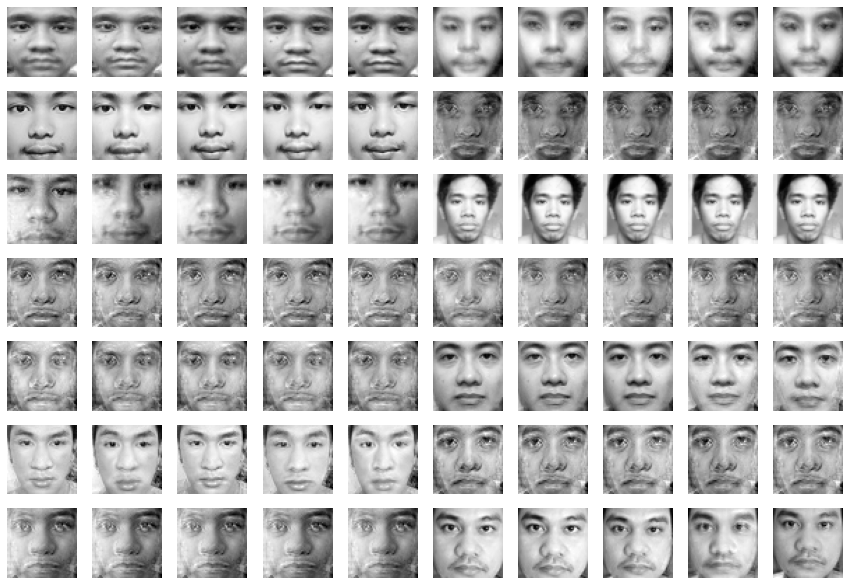

In [13]:
plt.figure(figsize = (1*10*1.5,1*7*1.5))

for i in range(70):
    plt.subplot(7,10,i+1)
    test_image = rgb2gray(plt.imread(faces[i])).flatten()
    reconstructed_image = reconstruct_image(15,test_image,mean).reshape((50,50))
    plt.imshow(reconstructed_image, cmap = 'gray')
    plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.2)
#plt.savefig('Figures/reconstructed_faces.png', dpi = 300, bbox_inches = 'tight')
plt.show()

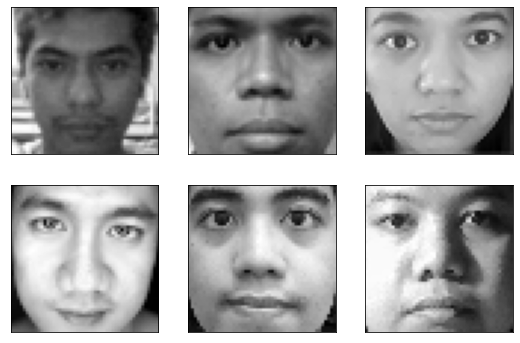

In [14]:
#Faces not constructed properly
indices = [15,30,35,40,55,60]

plt.figure(figsize = (9,6))
for i,j in enumerate(indices):
    plt.subplot(2,3,i+1)
    plt.imshow(rgb2gray(plt.imread(faces[j])), cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
#plt.savefig('Figures/excluded_images.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### Compute RMSE and SSIM

In [15]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity

In [16]:
RMSE = np.zeros([len(faces),len(faces)])
SSIM = np.zeros([len(faces),len(faces)])

for i,j in tqdm(enumerate(faces)):
    test_image = rgb2gray(plt.imread(j)).flatten()
    rmse = []
    ssim = []
    for component in range(len(faces)):
        reconstructed_image = reconstruct_image(component+1,test_image,mean).reshape((50,50))
        rmse_val = np.sqrt(mean_squared_error(test_image.reshape((50,50)),reconstructed_image))
        ssim_val = structural_similarity(test_image.reshape((50,50)).astype(float), reconstructed_image)
        rmse.append(rmse_val)
        ssim.append(ssim_val)
    RMSE[i] = np.array(rmse)
    SSIM[i] = np.array(ssim)

70it [00:08,  7.83it/s]


In [17]:
RMSE_grouped = RMSE.transpose().reshape(-1,5).mean(1).reshape(70,-1).T
SSIM_grouped = SSIM.transpose().reshape(-1,5).mean(1).reshape(70,-1).T

In [18]:
labels = ['Dawisan', 'Saret', 'Buco', 'Binamira', 'Leo', 'Villanueva', 'Rivera', 'Miranda', 'Narag', 'Onglao', 'Principe', 'Rubio', 'Sevilla', 'Troy']
colors = ['black','black','black','red','black','black','blue','green','orange','black','black','violet','pink','black',]
markers = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p']

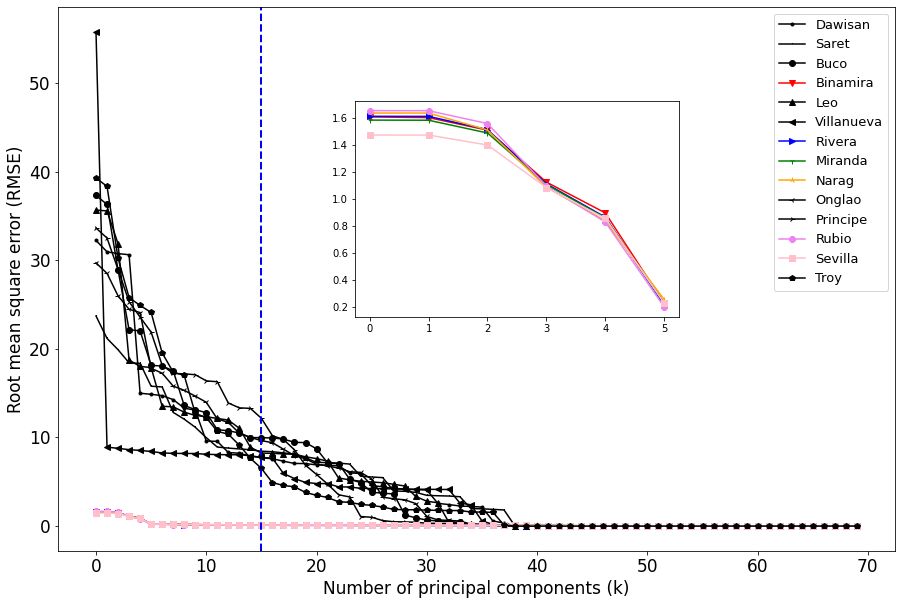

In [19]:
fig, ax1 = plt.subplots(figsize = (15,10))

left, bottom, width, height = [0.4, 0.45, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])
for i, j in enumerate(RMSE_grouped):
    ax1.plot(j, marker = markers[i], color = colors[i], label = labels[i])
    if colors[i] != 'black': 
        ax2.plot(j[0:6], marker = markers[i], color = colors[i], label = labels[i])

#ax2.set_xticks([])
#ax2.set_yticks([])
ax1.set_xlabel("Number of principal components (k)", fontsize = 17)
ax1.set_ylabel("Root mean square error (RMSE)", fontsize = 17)
ax1.legend(fontsize = 13)
ax1.tick_params(axis='both', which='major', labelsize=17)
ax1.axvline(x=k+1, color="blue", linewidth = 2, linestyle='dashed')
#plt.savefig('Figures/RMSE.png', dpi = 300, bbox_inches = 'tight')
plt.show()

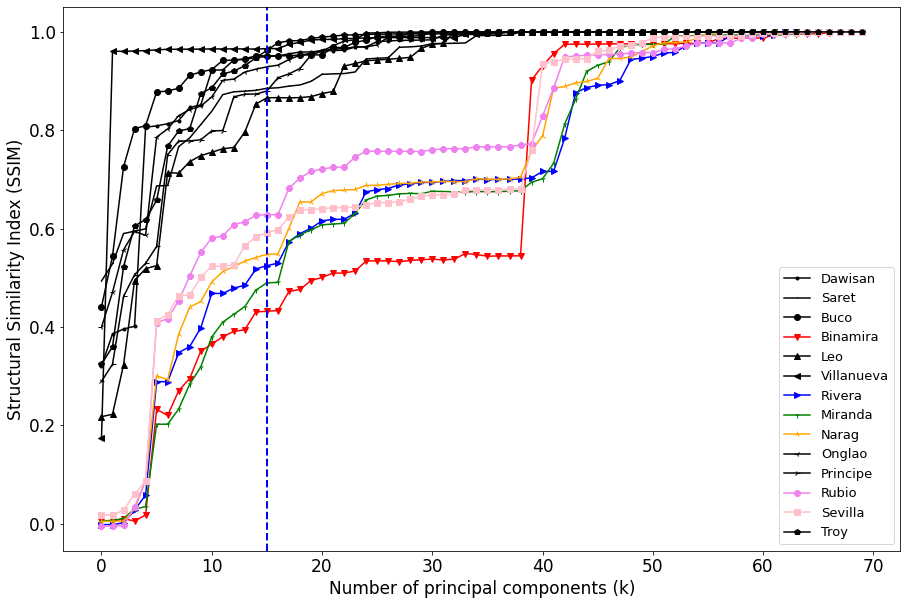

In [20]:
fig, ax1 = plt.subplots(figsize = (15,10))
for i, j in enumerate(SSIM_grouped):
    ax1.plot(j, marker = markers[i], color = colors[i], label = labels[i])

ax1.set_xlabel("Number of principal components (k)", fontsize = 17)
ax1.set_ylabel("Structural Similarity Index (SSIM)", fontsize = 17)
ax1.legend(fontsize = 13)
ax1.tick_params(axis='both', which='major', labelsize=17)
ax1.axvline(x=k+1, color="blue", linewidth = 2, linestyle='dashed')
#plt.savefig('Figures/SSIM.png', dpi = 300, bbox_inches = 'tight')
plt.show()

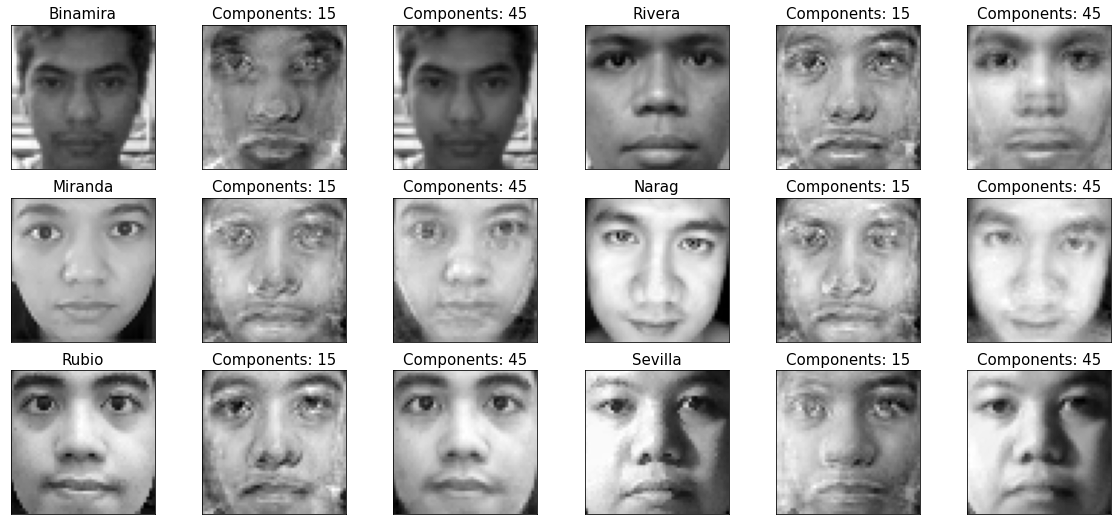

In [21]:
# Reconstructing the face using different principal components
#setting different amounts of K
ks = [15, 45]
names = ['Binamira', 'Rivera', 'Miranda', 'Narag', 'Rubio', 'Sevilla']

plt.figure(figsize=[20,9])
for m,j in enumerate(indices):
    test_image = rgb2gray(plt.imread(faces[j])).flatten()
    for i in range(2+1):
        plt.subplot(3,6,i+1+(3*m))
        if i == 0: 
            plt.imshow(test_image.reshape((50,50)), cmap = 'gray')
            plt.title(names[m], fontsize = 15)
            plt.xticks([])
            plt.yticks([])
        else:
            reconstructed = reconstruct_image(ks[i-1],test_image,mean)
            recons = reconstructed.reshape((50, 50))
            plt.imshow(recons, cmap = 'gray')
            plt.title("Components: "+str(ks[i-1]), fontsize = 15)
            plt.xticks([])
            plt.yticks([])

plt.subplots_adjust(wspace=0.2, hspace=0.2)
#plt.savefig('Figures/reconstructed_special_faces.png', dpi = 300, bbox_inches = 'tight')
plt.show()